In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import ctypes as ct
import scipy.interpolate
from aerofiles.igc import Reader



#import plotly.graph_objects as go

import pandas as pd

from datetime import datetime



In [2]:
# Function to read airfoil data at each station

def GetAirfoilData(Filename):
    with open(Filename, 'r') as infile:
        AirfoilData = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)
    
    return AirfoilData

In [3]:
# Function to read wing geometry

def GetWingData(Filename):
    with open(Filename, 'r') as infile:
        WingData = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)
    area = 0
    span = 0
    
    for i in range(0,len(WingData[0]),1):
        span = span + WingData[2][i]
        area = area + ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
    AR = 2*(span**2)/area
    
    return area, span,AR,WingData
    



In [4]:
def CallXfoilcl(Cl, Re, AirfoilName, Flap):

    mydll = ct.cdll.LoadLibrary('./XFOIL.dll');
    ISCONV = ct.c_bool(False)
    RE_IN = ct.c_double(Re)
    CL_IN = ct.c_double(Cl)
    array = (ct.c_double * 11) (0,0,0,0,0,0,0,Flap,0.86,-0.008,0)


    my_string = AirfoilName.encode() # Convert string to bytes

    _= mydll.xfoil_cl(ct.byref(array), ct.byref(CL_IN),ct.byref(RE_IN),ct.byref(ISCONV),ct.c_char_p(my_string));

            # Array1(1) = ADEG
            # Array1(2) = CD
            # Array1(3) = CDF
            # Array1(4) = CM
            # Array1(5) = HMOM
            # Array1(6) = HFX
            # Array1(7) = HFY
    if ISCONV.value is False:
        print(AirfoilName, Re, Cl)
        
    #print(ISCONV.value)
    return array[0],array[1],array[3]        
                

In [5]:
# sample code

rho = 1.225
mu = 1.789e-5
V_inf = 60  #[m/s]
alpha = 5   # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi  # lift curve slope
Weight = 550*9.81  #[N]
Bank_Angle = 0    #[deg]
Flap = 5
Pressure_altitude = 0  #[m]
OAT = 15


Re = rho*V_inf*1/mu
    
# call XFOIL DLL
AOA, Cd,Cm = CallXfoilcl(1.2,Re,'./N13',Flap);
print("Cd=" + str(Cd) + "  " + "AOA=" + str(AOA))


Cd=0.009115111082792282  AOA=6.507237434387207


In [6]:
#SAMPLE CODE

Area,Span,AR, WingData = GetWingData("wing_18.dat")
print(WingData)
print("Number of panels => " + str(WingData[0].size))
print("Aspect Ratio => " + str(AR))
print("Area => " + str(Area*2))
print("Span => " + str(Span*2))
#print(dir(WingData))

[[ 0.756       0.718       0.615       0.479       0.32      ]
 [ 0.718       0.615       0.479       0.32        0.2       ]
 [ 1.598       2.602       1.8         2.168       0.892     ]
 [ 1.17700929  1.73317762  0.98190798  0.8606      0.2194    ]
 [ 2.          2.          4.24        6.47       18.93      ]
 [ 1.59702753  2.60041654  1.79507858  2.154       0.84444444]]
Number of panels => 5
Aspect Ratio => 32.86897135803803
Area => 9.989189999999999
Span => 18.119999999999997


In [7]:
#SAMPLE CODE

AirfoilData  = GetAirfoilData("Airfoil_Data.dat")
print(AirfoilData)


for i in range(0,len(AirfoilData[0]),1):
    Re = rho*V_inf*float(AirfoilData[1][i])/mu
    
    # call XFOIL DLL
    #AOA, Cd,Cm = CallXfoilcl(0,Re,AirfoilData[0][i],0)
    
    print(i+1,AirfoilData[1][i],Re,AOA, Cd, Cm)
    

[['./B20' './BeT1' './T12' './TeN1' './N13' './N16']
 ['0.756' '0.718' '0.615' '0.479' '0.32' '0.20']]
1 0.756 3105980.9949692567 6.507237434387207 0.009115111082792282 -0.08193004876375198
2 0.718 2949860.2571268864 6.507237434387207 0.009115111082792282 -0.08193004876375198
3 0.615 2526690.888764673 6.507237434387207 0.009115111082792282 -0.08193004876375198
4 0.479 1967942.9849077696 6.507237434387207 0.009115111082792282 -0.08193004876375198
5 0.32 1314700.9502515371 6.507237434387207 0.009115111082792282 -0.08193004876375198
6 0.20 821688.0939072107 6.507237434387207 0.009115111082792282 -0.08193004876375198


In [8]:
# Function to divide wing into n sections, returns chord lengths array
#NOT USED


def WingDivide(WingData,n):
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[5]:
            span = span + panel_length 
    else:
        span = WingData[5]
        
    #print("Wing span => " + str(2*span))
    
    
    # divide wing into n sections
    chords = np.zeros(n, dtype=float)
    current_panel = 0 
    current_span_pos = WingData[5][0]
    i = 0
    for y_pos in np.linspace(0,span, n):
           
        if y_pos > current_span_pos:
            current_panel = current_panel + 1
            current_span_pos = current_span_pos + WingData[5][current_panel]
        
        chords[i] = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[5][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
        i += 1
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(np.stack((np.linspace(0,span,n),chords),axis=1))
 
    
    

In [9]:
def Get_Chord(WingData,y_pos):
    chord = 0
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[2]:
            span = span + panel_length 
    else:
        span = WingData[2]
        
    #print("Wing half span => " + str(span))
    
    
   
   
    current_panel = 0
    current_span_pos = WingData[2][0]   #outer section of current panel
     
    while current_panel <= number_of_panels+1:
        if y_pos < current_span_pos:
                chord = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[2][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
                break
        
        current_panel += 1 
        current_span_pos = current_span_pos + WingData[2][current_panel]
               
        #print(current_panel,current_span_pos)
        
    
    
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(chord)

In [10]:
def Solve_LL(wingdata,span,AR,a,n):
    
    #a is the lift slope cl/radians  -> 2*PI
    alpha = 5
    theta_range = np.linspace(90,0.01,n)
    AMatrix = np.ones(shape=(n,n))
    X = np.ones(n)
    delta = 0
    Cl = np.zeros(n)
    y_pos = np.zeros(n)
    
    
    i = 0
    for theta in theta_range:
        unit_y = -math.cos(np.deg2rad(theta)) 
        c = Get_Chord(wingdata,-unit_y*span)
        mu = c*a/(8*span)
        
        X[i] = mu*(np.deg2rad(alpha))*(math.sin(np.deg2rad(theta)))
        for j in range(0,n,1):
            AMatrix[i][j] = (math.sin(((j+1)*2 -1)*np.deg2rad(theta)))*(((j+1)*2-1)*mu + (math.sin(np.deg2rad(theta))))
        
        y_pos[i] = -unit_y*span
        i+=1
    
    #print(A)
    #print(X)      
    #A = np.matmul(np.linalg.inv(AMatrix),X)
    A = np.linalg.solve(AMatrix, X)
    
    
    for i in range(1,n,1):
        delta = delta +((i+1)*2-1)*(A[i]**2)/(A[0]**2)

    #e =  (1/(1+delta))     

    k = 0
    for theta in theta_range:  
        for j in range(0,n,1):
            unit_y = -math.cos(np.deg2rad(theta))
            c = Get_Chord(wingdata,-unit_y*span)
            Cl[k] = Cl[k]+ (8*span)*(A[j]*(math.sin(((j+1)*2-1)*np.deg2rad(theta)))) / c
            
        k+=1
           
    CL = A[0]*(np.pi)*AR
    Cl_unit = Cl/CL
    return(Cl_unit,y_pos,CL,delta) 
          
    

Span efficiency delta => 0.020374621855408743
CL => 0.515664194792368


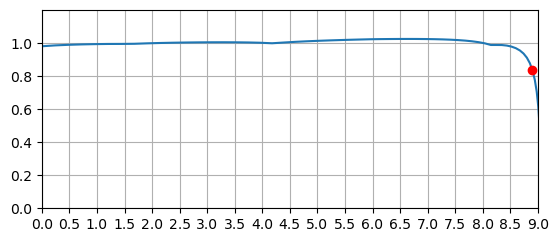

In [11]:
# SAMPLE CODE

n = 60
a = 2*np.pi

Area,Span,AR, WingData = GetWingData("wing_18.dat")
Cl,y_pos,CL,Delta = Solve_LL(WingData,Span,AR,a,n)   

print("Span efficiency delta => " + str(Delta))  
print("CL => " + str(CL))
#print(Cl)                 #Unit local Cl distribution
#print(y_pos)                 #span position for each local lift coefficient)


fig, ax = plt.subplots()
ax.set(xlim=(0, 9), xticks=np.arange(0, 9.5,0.5),
       ylim=(0, 1.2), yticks=np.arange(0, 1.2,0.2))
ax.plot(y_pos, Cl)
Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
ax.plot(spanpoint,Cl_interp(spanpoint),'ro')
ax.grid(True)
ax.set_box_aspect(0.4)
plt.show()



In [12]:
def Standard_Atmosphere(FileName,Elevation, standard_rho):
    
    with open(FileName, 'r') as infile:
        S_atm_Data = np.loadtxt(infile, dtype=float, skiprows=1, unpack=True)
    
    
    pressure_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[2])
    density_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[3])
    Kin_viscosity_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[4])
   
    pressure = pressure_interp(Elevation)
    rho = standard_rho* density_interp(Elevation)
    mu = rho * Kin_viscosity_interp(Elevation)* 1e-5
    
    #print(pressure_interp)
    #print(S_atm_Data)
    
    
    return(pressure, rho,mu)

In [13]:
def Get_rho_mu(P_altitude, OAT,rho):
    # standard rho 
    
    P,rho, mu= Standard_Atmosphere("Standard_atmosphere.txt", P_altitude,rho)
    
    R = 287.058
    T = OAT + 273.15
    
    P = P*100000
    
    
    return((P/(R*T)),mu)

In [14]:
#SAMPLE CODE

P,rho, mu = Standard_Atmosphere("Standard_atmosphere.txt", 3000,1.225)
print(rho,mu)
OAT = 34
rho, mu = Get_rho_mu(3455,OAT,1.225)
print(rho,mu)

0.9093175 1.6940585025000002e-05
0.7504899800532416 1.679334327125e-05


In [15]:
# SAMPLE CODE


Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
print(Cl_interp(spanpoint))


0.8367119987528993


In [16]:
def Wing_CD(WingFileName,AirfoilFileName,V,rho,mu,bank_angle,weight,Flap,a):
   
    # get wing definition data
    Area,Span,AR, WingData = GetWingData(WingFileName)
    
    
    
    # calculte span efficiency and cl-distribution
    n = 60
    cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,a,n)   

    #set cl interpolation function 
    cl_interp = scipy.interpolate.interp1d(y_pos,cl)


    CL = (2*weight) / (rho*(V**2)*2*Area*np.cos(np.deg2rad(bank_angle)))


    # calculate profile drag of the wing


    AirfoilData  = GetAirfoilData(AirfoilFileName)


    drag = 0
    area = 0
    span = 0.02



    Re_root = rho*V*float(AirfoilData[1][0])/mu
    AOA, Cd_root,Cm = CallXfoilcl(cl_interp(span)*CL,Re_root,AirfoilData[0][0],Flap)

    #print(span,cl_interp(span)*CL,AOA,Cd_root,Re_root)
    for i in range(0,len(WingData[0]),1):


        Re_tip = rho*V*float(AirfoilData[1][i+1])/mu

        span = span + 0.995*WingData[2][i]
        area = ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]

        # call XFOIL DLL


        AOA, Cd_tip,Cm = CallXfoilcl(cl_interp(span)*CL,Re_tip,AirfoilData[0][i+1],Flap)
        #print(span,cl_interp(span)*CL,AOA,Cd_tip,Re_tip)



        drag = drag + 0.5*rho*(V**2)*((Cd_root+Cd_tip)/2)*area

        Cd_root = Cd_tip

    CDi = ((CL**2)/(np.pi * AR)) * (1 + delta)
    CD = 2*drag/(rho*(V**2)*Area) + CDi
    

    return(CD,CL)
    

In [17]:
def Fuselage_Drag(FileName,V):
    with open(FileName, 'r') as infile:
        Fuselage_Data = np.loadtxt(infile, dtype=float, skiprows=1, unpack=True)
        
        
    #print(Fuselage_Data)
    
    drag_interp = scipy.interpolate.interp1d(Fuselage_Data[0],Fuselage_Data[1])
    
    #Drag = drag_interp(V)
    
    #Drag is in Newtons
    return(drag_interp(V))




In [18]:
#SAMPLE CODE


rho = 1.225
mu = 1.789e-5
V_inf = 60  #[m/s]
alpha = 5   # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi  # lift curve slope
Weight = 550*9.81  #[N]
Bank_Angle = 0    #[deg]
Flap = 5
Pressure_altitude = 0  #[m]
OAT = 15


#Optional call
Area,Span,AR, WingData = GetWingData("wing_18.dat")
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))

rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)
print(rho,mu)

CD,CL = Wing_CD("wing_18.dat","Airfoil_Data.dat",V_inf,rho,mu,Bank_Angle,Weight,Flap,a)
print("CD=" + str(CD) + "  " + "CL=" + str(CL))



Drag = Fuselage_Drag("JS3_Fuselage.dat",V_inf) + (0.5*rho*(V_inf**2)*CD*Area*2) * 1.1

print(Weight/Drag)


Area=9.989189999999999  Span=18.119999999999997  AR=32.86897135803803
1.2249781262066513 1.7897250000000002e-05
CD=0.0065331885804850815  CL=0.24496305198073073
22.64273376979759


In [21]:
# IGC FILE PARCER MODULE


Weight = 550*9.81  #[N]

rho_SL = 1.225
mu = 1.789e-5
alpha = 5   # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi  # lift curve slope

Flap = 13.5

WingFile = 'wing_18.dat'
FuselageFile = 'JS3_Fuselage.dat'
AirfoilsFile = 'Airfoil_Data.dat'

IGC_File = '153V6JU1.igc'
Output_File = 'OUTPUT.txt'




# Get wing parameters
Area,Span,AR, WingData = GetWingData(WingFile)
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))



with open(IGC_File, 'r') as f:
	IGC_Data = Reader().read(f)

i = 1500
    
TAS_previous = IGC_Data["fix_records"][1][i-1]["TAS"]                           #True airspeed
AOR_previous = IGC_Data["fix_records"][1][i-1]["AOR"]                           #Angle of roll
pressure_alt_previous = IGC_Data["fix_records"][1][i-1]["pressure_alt"]         #Pressure altitude
time_previous = IGC_Data["fix_records"][1][i-1]["time"]  

    
file = open(Output_File,"w")

#while i < len(IGC_Data['fix_records'][1]):
while i < 1505:
    
    TAS = IGC_Data["fix_records"][1][i]["TAS"]                           
    AOR = IGC_Data["fix_records"][1][i]["AOR"]                           
    OAT = IGC_Data["fix_records"][1][i]["OAT"]                           
    #VAR = IGC_Data["fix_records"][1][i]["VAR"]                               # Uncompensated variometer 
    pressure_alt = IGC_Data["fix_records"][1][i]["pressure_alt"]         
    time_now = IGC_Data["fix_records"][1][i]["time"]  
    
    V = (TAS_previous + TAS)/720
    Bank_Angle = (AOR_previous + AOR)/2
    #print(i,V)

    FMT = '%H:%M:%S'
    tdelta = datetime.strptime(str(time_now), FMT) - datetime.strptime(str(time_previous), FMT)
    

    timestep = tdelta.seconds
    
    Delta_H = pressure_alt - pressure_alt_previous
 
 
    
    Sink_V = Delta_H/timestep
    
        
    if (V > 15):   # above 25m/s  do calcs
        rho, mu = Get_rho_mu(pressure_alt,OAT/10,rho_SL)
        CD,CL = Wing_CD(WingFile,AirfoilsFile,V,rho,mu,Bank_Angle,Weight,Flap,a)
        #print("CD=" + str(CD) + "  " + "CL=" + str(CL) + " Time: "+ str(time_now))
        
        
        Drag = Fuselage_Drag(FuselageFile,V) + (0.5*rho*(V**2)*CD*Area*2) * 1.1
        Performance_Sink_V = -V/(Weight/Drag)
        
        print("Time: "+ str(time_now))
        print(V*3.6,Sink_V, Performance_Sink_V,Bank_Angle,CD,CL)
        file.write( str(datetime.strptime(str(time_now),FMT)) + ","+ str(V) + ","+ str(Sink_V) + "," + str(Performance_Sink_V) + "," +str(Bank_Angle) +"\n")
        #file.write( str(datetime.strptime(str(time_now),FMT)) + ","+ str(V) + ","+ str(Sink_V) + "," + str(Performance_Sink_V) + "," + str(VAR/100)+"," +str(Bank_Angle) +"\n")
    else:
        Drag = 0



    i += 1

    TAS_previous = TAS
    AOR_previous = AOR
    pressure_alt_previous = pressure_alt
    time_previous = time_now
    
    
file.close()
print("Done")

    
    

Area=9.989189999999999  Span=18.119999999999997  AR=32.86897135803803
Time: 11:31:56
116.84 5.0 -0.8896673368269444 -38.5 0.02050218698170641 1.178621873153793
Time: 11:31:57
115.225 4.0 -0.8738298738425913 -37.5 0.021016758240503804 1.195621892217377
Time: 11:31:58
113.63499999999999 3.0 -0.8354828118425228 -35.0 0.0208996288965597 1.190598235235539
Time: 11:31:59
112.455 2.0 -0.7961503813661631 -32.0 0.02049364929763235 1.1754161596462476
Time: 11:32:00
111.325 3.0 -0.7679096779238164 -29.5 0.020328090821212137 1.1686586718209295
Done


In [20]:
# SAMPLE CODE
# Moving average calc

# ACZ - G-forces
# AOR - Roll angle
# AOP - Pitch angle

with open('153V6JU1.igc', 'r') as f:
	parsed_igc_file = Reader().read(f)

    
for infos,iv2 in list(parsed_igc_file.items()):			
	print(infos)
    
    
print (parsed_igc_file["fix_record_extensions"][1][1])
    
print (len(parsed_igc_file['fix_records'][1]))
print (parsed_igc_file["fix_records"][1][200]["TAS"])
print (parsed_igc_file["fix_records"][1][1000])
print (parsed_igc_file["fix_records"][1][1001])
   
window_size = 5
  
i = 0

TAS_MA = []
AOR_MA = []


window = []
moving_averages = []



# file = open("AOR.txt","w")
# i = 0
# while i < len(parsed_igc_file['fix_records'][1]) - window_size + 1:
    
#     if i < window_size:
#         window.append(parsed_igc_file["fix_records"][1][i]["AOR"])
  
#     else:
#         window.append(parsed_igc_file["fix_records"][1][i]["AOR"])
#         window.pop(0)
#         window_average = round(sum(window) / window_size, 2)
#         moving_averages.append(window_average)
#         file.write(str(parsed_igc_file["fix_records"][1][i]["AOR"]) + " " + str(window_average) +" " +str(parsed_igc_file["fix_records"][1][i]["OAT"]/10) + "\n")
#     i += 1

# file.close()





logger_id
fix_records
task
dgps_records
event_records
satellite_records
security_records
header
fix_record_extensions
k_record_extensions
k_records
comment_records
{'bytes': (39, 41), 'extension_type': 'ENL'}
10096
14339
{'time': datetime.time(11, 23, 36), 'lat': 43.98683333333334, 'lon': -0.9818333333333332, 'validity': 'A', 'pressure_alt': 1577, 'gps_alt': 1699, 'FXA': 6, 'ENL': 4, 'TAS': 10670, 'GSP': 10127, 'HDT': 250, 'TRT': 254, 'VAT': -10, 'OAT': 13, 'MOP': 1, 'ACZ': 110, 'AOR': -34, 'AOP': 7, 'RPM': 0, 'EGT': 12, 'FFL': 0, 'FLE': 3573}
{'time': datetime.time(11, 23, 37), 'lat': 43.98675, 'lon': -0.9821666666666666, 'validity': 'A', 'pressure_alt': 1576, 'gps_alt': 1698, 'FXA': 6, 'ENL': 4, 'TAS': 10755, 'GSP': 10141, 'HDT': 237, 'TRT': 241, 'VAT': 0, 'OAT': 14, 'MOP': 1, 'ACZ': 110, 'AOR': -30, 'AOP': 6, 'RPM': 0, 'EGT': 11, 'FFL': 0, 'FLE': 3573}
